**Estude a teoria da PCA para problemas com amostras pequenas**, onde o número de pontos de dados é menor
que a dimensão do espaço de dados (veja [3] ou a seção 12.1.4 de [1]). Escolha um banco de dados de imagens ([6],
por exemplo), converta as imagens para tons de cinza e aplique a teoria de ‘PCA para problemas com amostras pequenas’
para a redução de dimensionalidade.

1. **Seja** x a média amostral (centróide do conjunto de dados) e p1 o componente principal. Visualize o
   resultado da expressão:

   x = x + αp1

   onde α ∈ {−βλ1, 0, βλ1} com λ1 sendo o autovalor associado a p1
   e β um fator escalar (veja [5]).

2. **Estude o espectro da matriz** X^T X para realizar a redução de dimensionalidade. Visualize algumas
   imagens no espaço de dimensão reduzida.

3. **Construa um gerador de imagens** usando os d componentes principais escolhidos no item (2).



In [1]:
import os
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA

Carregando conjunto de imagens:

In [2]:
image_dir = './dataset-FEI/frontalimages_spatiallynormalized/'
images = []
image_paths = []

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    img = Image.open(img_path)
    img = img.resize((260, 360))  # Ajuste o tamanho conforme necessário
    img_array = np.array(img)
    images.append(img_array)
    image_paths.append(img_path)  # Guarda o caminho para referência futura

images = np.array(images)


In [4]:
images.shape

(400, 360, 260)

Plotando imagem exemplo:

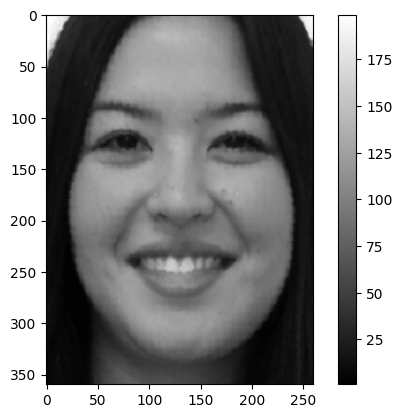

In [5]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(images[99], cmap='gray')
plt.colorbar()
plt.grid(False)

Vetorizando imagens:

In [6]:
# Achatar as imagens em (n_samples, height * width)
images_vetorizada = images.reshape(images.shape[0], -1)

In [7]:
images_vetorizada.shape

(400, 93600)

Calcula a matriz de dados centralizados:

In [8]:
# media global de todos os elementos
global_mean = np.mean(images_vetorizada, axis=0)

# centraliza a matriz de dados
X = images_vetorizada - global_mean

Imagem media:

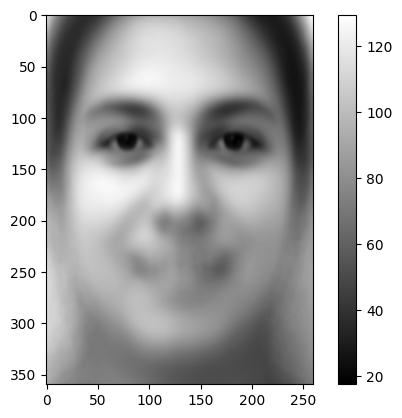

In [9]:
plt.figure()
plt.imshow(global_mean.reshape(360,260), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

Para o problema de Small size, encontrando autovalores e autovetores de XX^T:

In [10]:
X_T = np.transpose(X)
V = np.dot(X, X_T) / len(X[0])

autovalores, autovetoresV = np.linalg.eigh(V)

In [11]:
autovetoresV.shape

(400, 400)

Multiplica por X^T para encontrar autovetores de S=(X^T)X e normaliza.

In [12]:
autovetores = np.dot(X_T, autovetoresV)

In [13]:
autovetores = autovetores / np.linalg.norm(autovetores, axis=0)

In [14]:
autovetores.shape

(93600, 400)

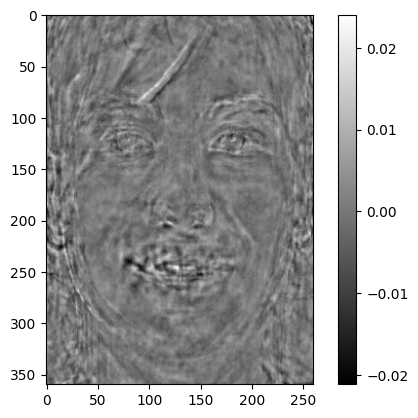

In [18]:
padroes = autovetores[:,8].reshape(360,260)
plt.figure()
plt.imshow(padroes, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [19]:
ordem_decrescente = np.argsort(autovalores)[::-1]
autovalores = autovalores[ordem_decrescente]
autovetores = autovetores[:, ordem_decrescente]

In [20]:
autovetores.shape

(93600, 400)

Análise do espectro da matriz para seleção de truncamento:

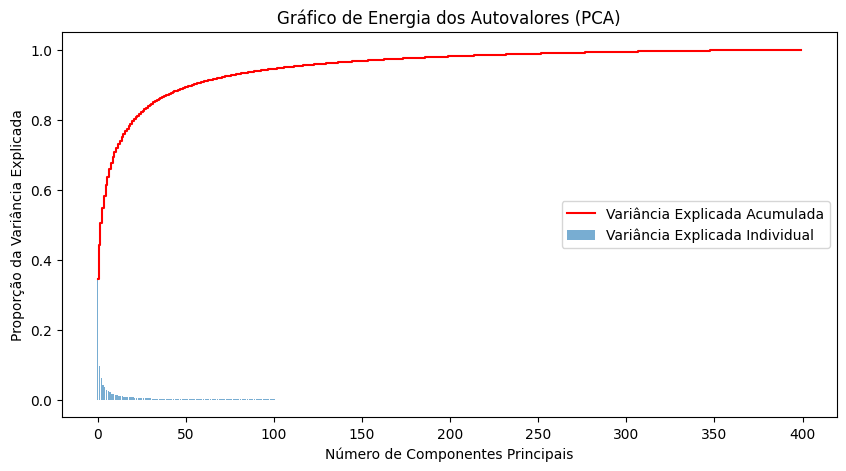

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Passo 1: Calcular a variância explicada
variancia_explicada = autovalores / np.sum(autovalores)

# Passo 2: Calcular a variância explicada acumulada
variancia_explicada_acumulada = np.cumsum(variancia_explicada)

# Passo 3: Plotar o gráfico de energia dos autovalores
plt.figure(figsize=(10, 5))
plt.bar(range(len(variancia_explicada)), variancia_explicada, alpha=0.6, label='Variância Explicada Individual')
plt.step(range(len(variancia_explicada_acumulada)), variancia_explicada_acumulada, where='mid', color='red', label='Variância Explicada Acumulada')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Proporção da Variância Explicada')
plt.title('Gráfico de Energia dos Autovalores (PCA)')
plt.legend(loc='best')
plt.show()


Realizando truncamento em 50:

In [41]:
import numpy as np

# Criar uma matriz de zeros 400x400
matriz = np.zeros((400, 400))

# Definir os primeiros 50 elementos da diagonal como 1
np.fill_diagonal(matriz[:50, :50], 1)

# Multiplicação da matriz de autovetores pela identidade truncada
autovetores_truncados = np.dot(autovetores, matriz)


In [44]:
autovetores_truncados.shape

(93600, 400)

In [23]:
x_tranformado = np.dot(images_vetorizada, autovetores)

In [24]:
x_tranformado.shape

(400, 400)

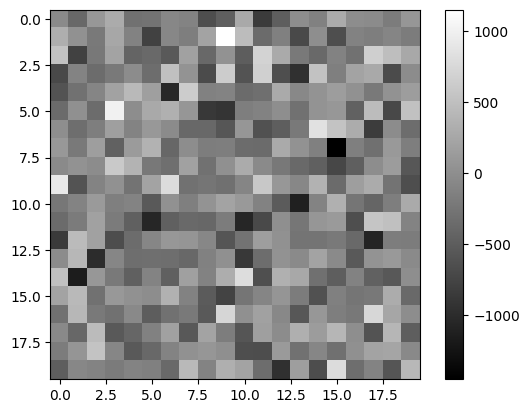

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_tranformado[:,55].reshape(20,20), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

Text(0.5, 1.0, 'PCA - Visualização de Imagens no Espaço das Componentes Principais')

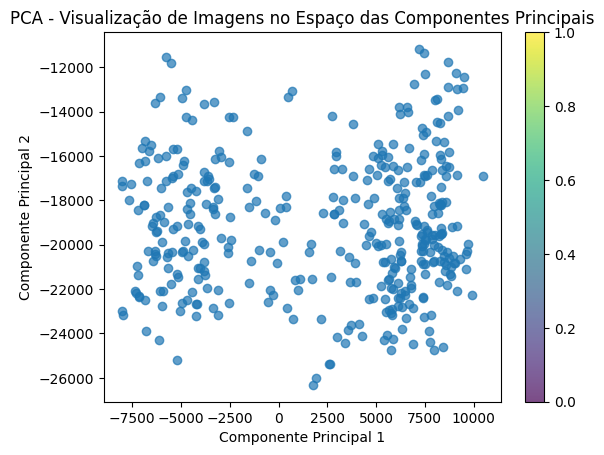

In [40]:
import numpy as np
import matplotlib.pyplot as plt


# Supondo que X_transformado tem 2 dimensões e Y são as labels
plt.scatter(x_tranformado[:, 0], x_tranformado[:, 1], alpha=0.7)
plt.colorbar()
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Visualização de Imagens no Espaço das Componentes Principais')


In [34]:
imagem_transformada = np.dot(x_tranformado, np.transpose(autovetores))+global_mean

In [37]:
imagem_editada = imagem_transformada[4].reshape(360, 260)

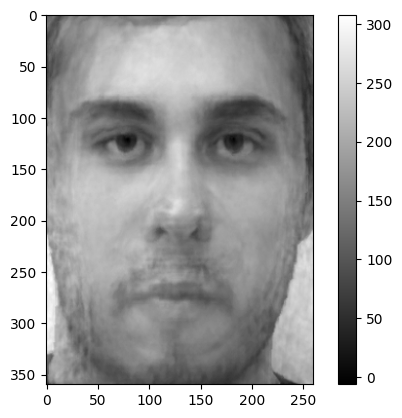

In [39]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imagem_editada, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

In [47]:
autovetores.shape

(93600, 400)

In [45]:
global_mean.shape

(93600,)

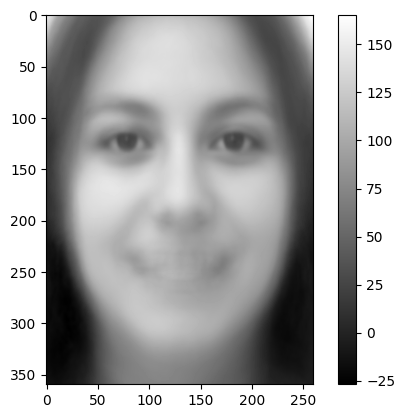

In [52]:
x = global_mean + np.transpose(autovetores[:,0])*autovalores[1]*-0.3
plt.figure()
plt.imshow(x.reshape(360,260), cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()